In [4]:
import pandas as pd 
import numpy as np 
import time 
import gc 

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import KFold, StratifiedKFold

from keras.models import Model
from keras.layers import Input, Dropout, Concatenate, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import CuDNNGRU, PReLU, GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence

from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from attention_with_context import AttentionWithContext
from Attention import Attention
from capsule import Capsule
import kaggle_util
import string

from keras import optimizers

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OMP_NUM_THREADS'] = '4'

import threading
import multiprocessing
from multiprocessing import Pool, cpu_count
from contextlib import closing
cores = 4

from keras import backend as K
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from lightgbm_avito import calcImgAtt

from gensim.models import Word2Vec

max_seq_title_description_length = 300
max_seq_title_length = 30
max_words_title_description = 200000
EMBEDDING_DIM1 = 300
emb_size = 10
gru_size = 50

debug = 1
nfold = 5

frm = 0
to = 1503424
if debug:    
    frm = 0
    to = 1000

In [5]:
train = pd.read_csv("../input/train.csv", skiprows=range(1,frm), nrows=to-frm, 
                        parse_dates=["activation_date"], 
                        index_col = "item_id")
y_train = np.array(train['deal_probability'])
len_train = len(train)

In [9]:
import parse_att
(selcol, how) = (['param_1', 'price'], ['zscore'])
train, sub_changed = parse_att.calcGroupFeatureBulk(train, selcol, how, frm, to, [])

group feature: param_1_price_zscore
calculate from scratch: param_1_price_zscore
['param_1', 'price']


ValueError: invalid literal for int() with base 10: 'ASUS'

In [4]:
dtypes_train = {
                'price': 'float32',
                'deal probability': 'float32',
                'item_seq_number': 'uint32'
}

# No user_id
train = pd.read_csv("../input/train.csv", skiprows=range(1,frm), nrows=to-frm, 
                    parse_dates=["activation_date"], 
                    dtype = dtypes_train, 
                    index_col = "item_id")
y_train = np.array(train['deal_probability'])
len_train = len(train)

#del train['deal_probability']
del train
gc.collect()

test = pd.read_csv("../input/test.csv", skiprows=range(1,frm), nrows=to-frm, index_col = "item_id", parse_dates = ["activation_date"])
testdex = test.index

#train = pd.concat([train, test], axis = 0)
del test
gc.collect()

nrow = 2 * (to - frm) if debug else None
train = pd.read_csv('/media/extend/cache/total_0_1503424.csv', nrows= nrow)
#train.drop(['Unnamed: 0', 'deal_probability','item_id'], axis=1, inplace=True)

In [ ]:
train.to_csv('/media/extend/cache/total_0_1503424.csv', index=False)

In [7]:
train.shape

(481533, 96)

In [5]:
for col in train.columns:
    if 'zscore' in col:
        train[col][train[col] < -4] = -4
        train[col][train[col] > 4] = 4

In [38]:
from rnn_all import get_numcols

emb_cols = ['user_id', 'region', 'city', 'category_name', 'parent_category_name', 'user_type',
            'param_1', 'param_2', 'param_3', 'img_label', 'reg_Time_zone', 'Weekday', 'image_top_1']

train.img_label.fillna('none', inplace=True)
encoder = LabelEncoder()
train['img_label'] = encoder.fit_transform(train['img_label'])

train['description'].fillna('none', inplace=True)
train['title'].fillna('none', inplace=True)

dict_emb_max = {}
for col in emb_cols:
    dict_emb_max[col] = train[col].max() + 2

num_cols = get_numcols(train, emb_cols)

for col in num_cols:
    train[col].fillna(0, inplace=True)
    train[col].replace(np.Inf, 0, inplace=True)
    train[col].replace(-np.Inf, 0, inplace=True)
    if 'zscore' in col:
        train[col][train[col] < -4] = -4
        train[col][train[col] > 4] = 4
    

In [39]:
col = 'city_category_name_param_1_price_zscore'
(train[col] < -4).sum()

0

In [24]:
scaler = MinMaxScaler()
for col in num_cols:
    print(col)
    
    train[col] = scaler.fit_transform(np.reshape(train[col].values, (-1,1)))
    

item_seq_number
price
latitude
longitude
reg_dense
rural
reg_Population
reg_Urban
avg_days_up_user
avg_times_up_user
n_user_items
population
whratio
area
laplacian
colorfull
brightness
median
rms
stddev
resnet_conf
xception_conf
inception_conf
desc_punc
description_num_chars
description_num_words
description_num_unique_words
description_words_vs_unique
description_punctuation
description_digit
description_num
description_num_letters
title_num_chars
title_num_words
title_num_unique_words
title_words_vs_unique
title_punctuation
title_digit
title_num
title_num_letters
title_desc_len_ratio
desc_num_ratio
city_category_name_param_1_count
city_category_name_param_1_cumcount
city_category_name_param_1_nunique
category_name_param_1_price_count
category_name_param_1_price_zscore
user_id_price_count
user_id_price_cumcount
user_id_category_name_param_1_price_count
user_id_category_name_param_1_price_cumcount
city_category_name_param_1_price_count
city_category_name_param_1_price_zscore


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

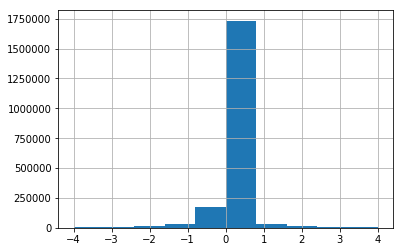

In [41]:
train.city_category_name_param_1_price_zscore.hist()

In [ ]:
train.category_name_param_1_price_zscore.is

In [42]:
scaler = MinMaxScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
train = kaggle_util.reduce_mem_usage(train)

  4%|▍         | 4/94 [00:00<00:02, 37.61it/s]

Memory usage of dataframe is 1442.83 MB


100%|██████████| 94/94 [00:09<00:00, 10.37it/s]


Memory usage after optimization is: 376.06 MB
Decreased by 73.9%


In [ ]:
train.info()

In [6]:
train['title_description']= (train['title']+" "+train['description']).astype(str)
print("Start Tokenization.....")
tokenizer = kaggle_util.get_text_tokenizer(train, 'title_description', max_words_title_description)

train['seq_description']= tokenizer.texts_to_sequences(train.description.str.lower())
train['seq_title']= tokenizer.texts_to_sequences(train.title.str.lower())

del train['description'], train['title'], train['title_description']
gc.collect()

Start Tokenization.....


69

In [7]:
EMBEDDING_FILE1 = '../input/wiki.ru.vec'
embedding_matrix1, vocab_size = kaggle_util.build_emb_matrix_from_tokenizer(tokenizer, EMBEDDING_FILE1, EMBEDDING_DIM1)

(15867, 300)
13122 2743 2743 13122
(15867, 300)


In [ ]:
train = kaggle_util.reduce_mem_usage(train)

In [ ]:
train.info()

In [ ]:
from rnn_all import get_keras_data, get_numcols

test = train[len_train:]
train = train[:len_train]
X_test = get_keras_data(test)
num_cols = get_numcols(test, emb_cols)
print('test shape: {}'.format(test.shape))
print('num_cols:')
print(num_cols)

In [ ]:
scaler = MinMaxScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [ ]:
n_fold = 5
skf = StratifiedKFold(y_train, n_folds=nfold)
i, (train_idx, test_idx) = next(enumerate(skf))

In [ ]:
def get_keras_data(dataset):
    X = {}
    for c in dataset.columns:
        if c in ['item_id']:
            continue   
        elif c == 'seq_description':
            X[c] = pad_sequences(dataset[c], maxlen=max_seq_title_description_length)
        elif c == 'seq_title':
            X[c] = pad_sequences(dataset[c], maxlen=max_seq_title_length)
        
        #if c == 'seq_title_description':
        #    X[c] = pad_sequences(dataset[c], maxlen=max_seq_title_description_length)
        else:
            X[c] = dataset[c].values
            

    print("Data ready for Vectorization")
    
    return X

In [1]:
X_train1, X_test1 = train.iloc[train_idx], train.iloc[test_idx]
print('input shape: ', X_train1.shape, X_test1.shape)
y_train1, y_test1 = y_train[train_idx], y_train[test_idx]
print(y_train1.shape, y_test1.shape)
gc.collect()

X_train_final = get_keras_data(X_train1)
X_test_final = get_keras_data(X_test1)
#del X_train1, X_test1
#gc.collect


# Initialize a new Model for Current FOLD 
epochs = 1
batch_size = 512 * 3
steps = (int(train.shape[0]/batch_size))*epochs
lr_init, lr_fin = 0.009, 0.0045
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
lr_decay = exp_decay(lr_init, lr_fin, steps)

NameError: name 'train' is not defined

In [ ]:
from rnn_all import RNN_model
modelRNN = RNN_model(emb_cols, num_cols, dict_emb_max, vocab_size)
K.set_value(modelRNN.optimizer.lr, lr_init)
K.set_value(modelRNN.optimizer.decay, lr_decay)